In [1]:
import stageemi
import stageemi.dev.visu as dev
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import stageemi.dev.decorator_map as dm
import ipywidgets as widg 
import ipyleaflet as ipyl
import datetime as dt
import os 
from ipywidgets import Text, HTML
from ipyleaflet import WidgetControl
import pandas as pd
from datetime import datetime
import glob 
import time

In [2]:
def conversion(ds,name):
    """convert wwmf into wme (compas) or w1 (agat) code"""
    
    file_CodesWWMF= '../utils/CodesWWMF.csv'
    df_WWMF = pd.read_csv(file_CodesWWMF,usecols = (0,1,2,3,6,7),sep=',')
        
    if name=="compas":
        var_name="wme_arr"
        col_name="Code WME"
        ds[var_name]=ds.unknown
        
    elif name=="agat":
        var_name="w1_arr"
        col_name="Code W1"
        ds[var_name]=ds.unknown       
        
    elif name=="compas_asym":
        var_name="wme_asym_arr"
        col_name="Code WME"
        ds[var_name]=ds.unknown
        
    elif name=="agat_asym":
        var_name="w1_asym_arr"
        col_name="Code W1"
        ds[var_name]=ds.unknown 

    for iwwmf,wwmf in enumerate(df_WWMF["Code WWMF"]):
        #print(wwmf,df_WWMF["Code WME"][iwwmf])
        ds[var_name]=ds[var_name].where(ds.unknown!=wwmf,df_WWMF[col_name][iwwmf])
        
    return ds

def distance(ds,name,**options):
    """calculate the distance between all possible temps sensibles (wme) and the temps sensibles of the zone"""
    
    if name == "compas":
        fname_dist = '../utils/distance_compas.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')
        var_name="wme_arr"
        varsh="wme_c_"
        
    elif name == "agat":
        fname_dist = '../utils/distance_agat.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')  
        var_name="w1_arr"
        varsh="w1_c_"
        
    elif name == "compas_asym":
        fname_dist = '../utils/distance_compas_asym.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')
        var_name="wme_asym_arr"
        varsh="wme_asym_c_"
        
    elif name == "agat_asym":
        fname_dist = '../utils/distance_agat_asym.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')  
        var_name="w1_asym_arr"
        varsh="w1_asym_c_"
    
        
    if options.get("action") == "test":
        """used to test over few pixels only in debug mode"""
        for iwme,wme in enumerate(df_dist):
            if iwme>0 and iwme<5:
                # initialize ds["1"] etc
                ds[wme]=ds.wme_arr
                for iiwme,wwme in enumerate(df_dist):
                    if iiwme>0:
                        #print(wme,wwme,iiwme,iwme)
                        #print(df_dist.iloc[iiwme-1,iwme])
                        # for a given wme (e.g. "1") every value in ds["1"] is replaced by the ditance btw wme and wwme
                        ds[wme]=ds[wme].where(ds.wme_arr!=int(wwme),df_dist.iloc[iiwme-1,iwme])  
                        
    else:
        for iw,w in enumerate(df_dist): 
            if iw>0:
                ds[varsh+w]=ds.wme_arr
                for iiw,ww in enumerate(df_dist):
                    if iiw>0:
                        ds[varsh+w]=ds[varsh+w].where(ds[var_name]!=int(ww),df_dist.iloc[iiw-1,iw])       
                    
    return ds  

def shortest_distance_temps_sensible(ds,name):
       
    if name=="compas": 
        varsh="wme_c_"
    elif name=="agat": 
        varsh="w1_c_"
    elif name=="compas_asym": 
        varsh="wme_asym_c_"
    elif name=="agat_asym": 
        varsh="w1_asym_c_"
    
    """find all newly added variables linked to wme or w1 resulting from the distance calulation"""
    allvar=list(ds.data_vars)
    list_w=[allvar[i] for i in np.where([varsh in s for s in allvar])[0]]
    ncodes=len(list_w)
    
    nstep=1#ds.dims["step"]    
    best_w=np.asarray(np.ones((1,nstep))*np.nan)  
    
    #add-on
    second_best_w=np.asarray(np.ones((1,nstep))*np.nan)
    best_w_dist=np.asarray(np.ones((1,nstep))*np.nan)  
    second_best_w_dist=np.asarray(np.ones((1,nstep))*np.nan)
    
    # start comment here
    #for istep in range(nstep):
    istep=0
        
    """used for debug"""
    dist_w=np.asarray(np.ones((1,ncodes))*np.nan) 

    best_w[0]=list_w[np.asarray([np.sum(ds[w]) for iw,w in enumerate(list_w)]).argmin()][len(varsh)::]
    dist_w[0]=np.asarray([np.sum(ds[w]) for iw,w in enumerate(list_w)])

    ds.attrs[name+" (step"+str(istep)+")"]=dist_w[0]

    #add-on (20200313 teletravail day - end of EMI)
    #xxxx_dist_best_class + xxxx_second_best_class + xxxx_dist_second_best_class + (xxxx_mean_dist + xxxx_std_dist)
    second_best_w[0]=list_w[(np.argsort(np.asarray([np.sum(ds[w]) for iw,w in enumerate(list_w)])))[1]][len(varsh)::]
    best_w_dist[0]=np.sort(dist_w[0])[0]
    second_best_w_dist[0]=np.sort(dist_w[0])[1]
        
    # end comment here
    
    """write the best wme code for each time step """
    ds.attrs[name]=best_w[0]    
    
    #add-on
    ds.attrs[name+" second-best-class"]=second_best_w[0]
    ds.attrs[name+" best-distance"]=best_w_dist[0]
    ds.attrs[name+" second-best-distance"]=second_best_w_dist[0]
    
    return ds    
    
def calculate_distance(ds,name):
   
    ds=conversion(ds,name)
    ds=distance(ds,name)
    ds=shortest_distance_temps_sensible(ds,name)
    
    return ds

In [3]:
def init_table_dist(zones_for_search):
    """initialise the table for the scores"""
    zone_index=zones_for_search
    df_dist=pd.DataFrame(columns=['WME','WME_dist','WME_second','WME_second_dist',
                                    'W1','W1_dist','W1_second','W1_second_dist',
                                    'WME_asym','WME_asym_dist','WME_asym_second','WME_asym_second_dist',
                                    'W1_asym','W1_asym_dist','W1_asym_second','W1_asym_second_dist',
                                    'WME_comp','WME_dist_comp','WME_second_comp','WME_second_dist_comp',
                                    'W1_comp','W1_dist_comp','W1_second_comp','W1_second_dist_comp',
                                    'WME_asym_comp','WME_asym_dist_comp','WME_asym_second_comp','WME_asym_second_dist_comp',
                                    'W1_asym_comp','W1_asym_dist_comp','W1_asym_second_comp','W1_asym_second_dist_comp'],index=zone_index)
    return df_dist

In [4]:
def store_results(df_dist,zone,ds_masked,**options):
    """store coherency results in df_scores"""
    
    for i, name in enumerate(["compas","agat","compas_asym","agat_asym"]):
        
        if options.get("action") == "comp": 
            #print("est ce qu on passe par la")
            df_dist.loc[zone].iloc[4*i+16]=ds_masked.attrs[name][0]
            df_dist.loc[zone].iloc[4*i+17]=ds_masked.attrs[name+" best-distance"][0]
            df_dist.loc[zone].iloc[4*i+18]=ds_masked.attrs[name+" second-best-class"][0]
            df_dist.loc[zone].iloc[4*i+19]=ds_masked.attrs[name+" second-best-distance"][0]
            
        else:
            df_dist.loc[zone].iloc[4*i]=ds_masked.attrs[name][0]
            df_dist.loc[zone].iloc[4*i+1]=ds_masked.attrs[name+" best-distance"][0]
            df_dist.loc[zone].iloc[4*i+2]=ds_masked.attrs[name+" second-best-class"][0]
            df_dist.loc[zone].iloc[4*i+3]=ds_masked.attrs[name+" second-best-distance"][0]
        
    return df_dist 

In [5]:
def save_df(df_dist,res_path,zone_dpt,time_str,echeance):
    """save df_dist in my distance result folder"""
    foutname=res_path+zone_dpt+"_"+"echeance_"+time_str+".csv"
    print('Currently saving file: '+foutname)
    df_dist.to_csv (foutname, index = True, header=True) 

In [9]:
path="../WWMF/"
time_str='202001260000'
fname=sorted(glob.glob(path+"*"+'20200126000000'+"*"))[0]
echeance=45

In [16]:
zone_dpt="41"
fname_mask='../GeoData/zones_sympo_multiples/'+zone_dpt+'_mask_zones_sympos.nc'
da_mask=xr.open_dataarray(fname_mask)

da_mask['latitude']=da_mask['latitude'].round(5)
da_mask['latitude']=da_mask['latitude'].round(5)

#zones=[zs for zs in da_mask.id.values.tolist() if "+" not in zs] #
zones=da_mask.id.values.tolist()
zones_for_search=zones[1::]
#zones_for_search

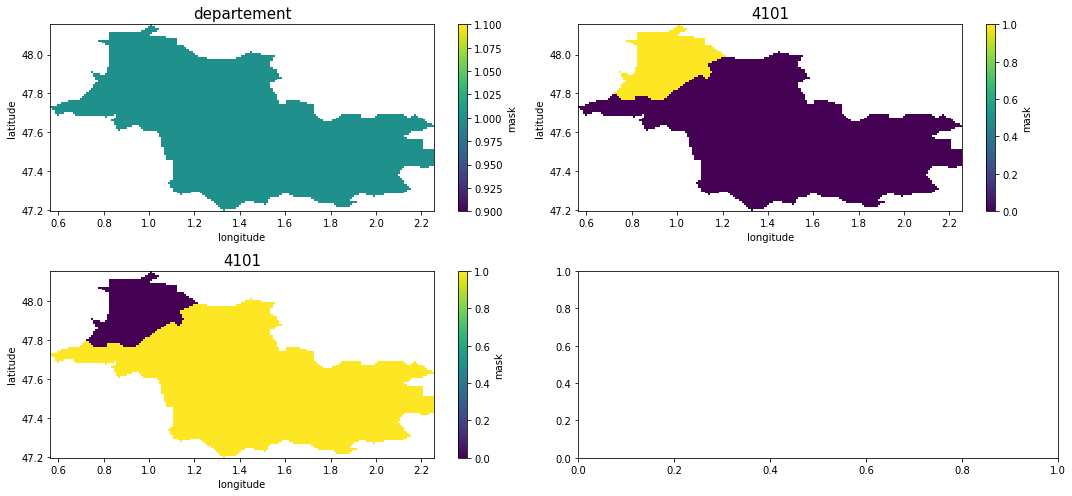

In [18]:
#check the complementary mask
fig,axes = plt.subplots(nrows=2,ncols = 2,figsize=(15,7))
ax = axes.flat

da=da_mask.sel(id=['departement','4101']).copy()
da1=da.sel(id='departement')-da.sel(id='4101')

for i in range(3):
    if i<2:
        da.isel(id=i).plot.imshow(ax=ax[i])
        ax[i].set_title(da.isel(id=i).id.values,fontsize=15)
    elif i==2:    
        da1.plot.imshow(ax=ax[i])
        ax[i].set_title(da.isel(id=1).id.values,fontsize=15)
        
plt.tight_layout()

In [21]:
start_time = time.time()
df_dist=init_table_dist(zones_for_search)

for izone, zone in enumerate(zones_for_search):
    
    print("currently processing zone:", zone)

    ds=xr.open_dataset(fname)

    """solve the bug observed when multiplying the mask by the dataset"""
    ds['latitude']=ds['latitude'].round(5)
    ds['longitude']=ds['longitude'].round(5)

    ds_masked=ds.isel(step=echeance)*da_mask.sel(id=zone)

    ds_masked=calculate_distance(ds_masked,"compas")
    ds_masked=calculate_distance(ds_masked,"agat")
    ds_masked=calculate_distance(ds_masked,"compas_asym")
    ds_masked=calculate_distance(ds_masked,"agat_asym")

    df_dist=store_results(df_dist,zone,ds_masked)

    #we repeat for the complementary of the mask (da_comp)
    print("and now the complementary zone:"+zone+"_comp")
    da_tmp=da_mask.sel(id=['departement',zone]).copy()
    da_comp=da_tmp.sel(id='departement')-da_tmp.sel(id=zone)

    ds_compmasked=ds.isel(step=echeance)*da_comp

    ds_compmasked=calculate_distance(ds_compmasked,"compas")
    ds_compmasked=calculate_distance(ds_compmasked,"agat")
    ds_compmasked=calculate_distance(ds_compmasked,"compas_asym")
    ds_compmasked=calculate_distance(ds_compmasked,"agat_asym")

    df_dist=store_results(df_dist,zone,ds_compmasked,action='comp')
    
print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
res_path="./distances_results/"
#save_df(df_dist,res_path,zone_dpt,time_str,echeance)